## Finding the Lyapunov Function using Counterexamples Method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from scipy.linalg import solve_continuous_lyapunov
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from dreal import *

import timeit 

import tqdm
import copy

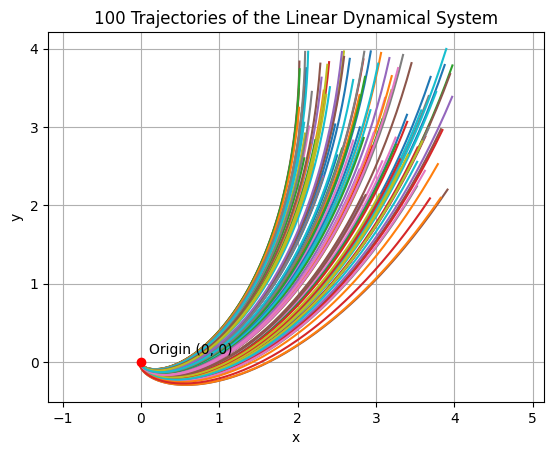

In [2]:
# System matrix
A = np.array([[-2, 1], [-1, -2]])

# Time
t = np.linspace(0, 10, 1000)

# Initial conditions
num_trajectories = 100
x0_values = np.random.uniform(low=2, high=4, size=(num_trajectories, 2))

X_data = np.zeros((len(t)*num_trajectories,2))
X_dot_data = np.zeros((len(t)*num_trajectories,2))

# Plotting trajectories
for i in range(num_trajectories):
    x = np.zeros((len(t), 2))
    x_dot = np.zeros((len(t), 2))
    x[0] = x0_values[i]
    for j in range(1, len(t)):
        x_dot[j-1] = np.dot(A, x[j-1])
        x[j] = x[j-1] + x_dot[j-1] * (t[j] - t[j-1])
    X_data[i*len(t):(i+1)*len(t),:] = x
    X_dot_data[i*len(t):(i+1)*len(t),:] = x_dot
    plt.plot(x[:, 0], x[:, 1])

# Plotting the origin
plt.plot(0, 0, 'ro')
plt.text(0.1, 0.1, 'Origin (0, 0)', fontsize=10)

plt.xlabel('x')
plt.ylabel('y')
plt.title('100 Trajectories of the Linear Dynamical System')
plt.grid(True)
plt.axis('equal')
plt.show()

In [3]:
Q = np.eye(2)
# Defining the Lyapunov Function
P = solve_continuous_lyapunov(A.T, -Q)
P = torch.tensor(P, dtype=torch.float32)
A = torch.tensor(A, dtype=torch.float32)

## Neural Network

In [4]:
#### Defining the Hyperparameters here
# Neural Network Structure
nn_h_f = 70
#nn_h_v = 50
nl_h_f = 1
#nl_h_v = 3
# Dimensions
nn_x = 2
TOL_LY = 0.0
TOL_LYG = 5
# Weights for the LOSS
DECAY_MSE = 1
DECAY_LY = 5
DECAY_LYG = 5
# Epochs
n_epochs_warm = 50
n_epochs = 300   # number of epochs to run

In [8]:
# NN for learning dynamics
class fNet(torch.nn.Module):
    def __init__(self,n_input, n_hidden1,  n_output):
        super().__init__()
        torch.manual_seed(2)
        self.layer1 = torch.nn.Linear(n_input, n_hidden1)
        self.layer2 = torch.nn.Linear(n_hidden1,n_output)   

    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = self.layer2(h_1) 
        return out

In [5]:
def lossFunction(model_f, model_v, X_batch, y_batch):
    # Calculate Loss of MSE from trajectory
    y_pred = model_f(X_batch)
    L1 = loss_fn(y_pred, y_batch)
    # Loss of Lyapunov Function being Positive
    L2 = torch.relu(-model_v(X_batch) + TOL_LY)
    # Loss of asymptotic property of Lyapunov Function
    X_batch.requires_grad = True # temporarily enable gradient
    y_batch_v = model_v(X_batch)
    gradient_boundary = torch.autograd.grad(
                torch.sum(y_batch_v),
                X_batch,
                grad_outputs=None,
                create_graph=True,
                only_inputs=True,
                allow_unused=True)[0]
    X_batch.requires_grad = False # temporarily disable gradient
    y_batch_f = model_f(X_batch)
    L3a = torch.sum(gradient_boundary*y_batch_f,dim=1)
    L3b = torch.norm(X_batch,dim=1)
    L3 = torch.relu(L3a + TOL_LYG * L3b)
    # Total Loss
    total_loss = DECAY_MSE * L1 + DECAY_LY * torch.sum(L2) + DECAY_LYG * torch.sum(L3)
    return total_loss

In [9]:
# Splitting Training and Test Data
X_train, X_test, y_train, y_test = train_test_split(X_data, X_dot_data, train_size=0.2, shuffle=False)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Defining the Neural Network
act_fn = nn.Tanh()
model_f = fNet(nn_x, nn_h_f, nn_x)
#model_f = genrateNN(nl_h_f, nn_h_f, nn_x, nn_x, act_fn)
#model_v = genrateNN(nl_h_v, nn_h_v, nn_x, 1, act_fn)

# Loss Function and Optmizer
loss_fn = nn.MSELoss()  # mean square error
optimizer_f = torch.optim.Adam(model_f.parameters(), lr = 0.0001)
#optimizer_v = torch.optim.Adam(model_v.parameters(), lr = 0.0001)

batch_size = 50  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

MSE: 0.00
RMSE: 0.01


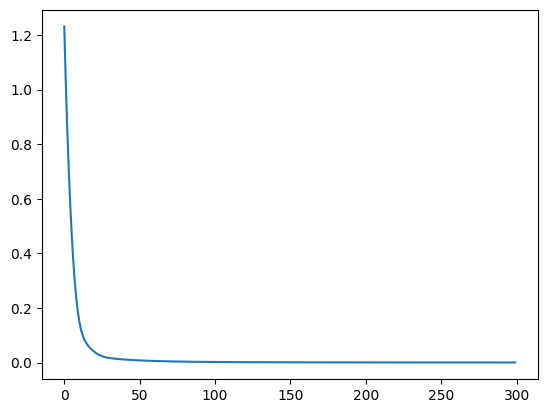

fNet(
  (layer1): Linear(in_features=2, out_features=70, bias=True)
  (layer2): Linear(in_features=70, out_features=2, bias=True)
)

In [10]:
for epoch in range(n_epochs):
    #model_v.train()
    model_f.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # Calculate the loss
            #loss = lossFunction(model_f, model_v, X_batch, y_batch);
            y_pred = model_f(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer_f.zero_grad()
            #optimizer_v.zero_grad()
            loss.backward() 
            optimizer_f.step()
            #optimizer_v.step()
            bar.set_postfix(mse=float(loss))
    #evaluate accuracy at end of each epoch
    model_f.eval()
    #model_v.eval()
    y_pred = model_f(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if loss < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model_f.state_dict())
    with torch.no_grad():
        torch.cuda.empty_cache()
# restore model and return best accuracy
model_f.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()
model_f.eval()

## Plot the Training Trajectories and the Output Trajectory taken by the model

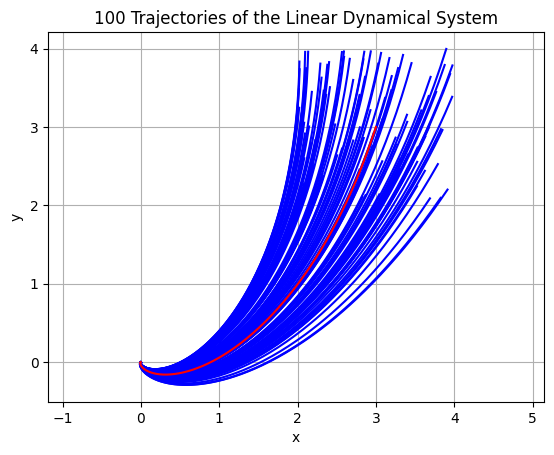

In [11]:
# Plotting trajectories
for i in range(num_trajectories):
    x = np.zeros((len(t), 2))
    x_dot = np.zeros((len(t), 2))
    x[0] = x0_values[i]
    for j in range(1, len(t)):
        x_dot[j-1] = np.dot(A, x[j-1])
        x[j] = x[j-1] + x_dot[j-1] * (t[j] - t[j-1])
    X_data[i*len(t):(i+1)*len(t),:] = x
    X_dot_data[i*len(t):(i+1)*len(t),:] = x_dot
    plt.plot(x[:, 0], x[:, 1],'b')

# Plotting the final trajectory
x = torch.zeros((len(t), 2))
x[0] = torch.tensor([3,3], dtype=torch.float32)
for j in range(1, len(t)):
    x[j] = x[j-1] + model_f(x[j-1]) * (t[j] - t[j-1])
x = x.detach().numpy()
plt.plot(x[:, 0], x[:, 1],'r')

# Plotting the origin
#plt.plot(0, 0, 'ro')
#plt.text(0.1, 0.1, 'Origin (0, 0)', fontsize=10)

plt.xlabel('x')
plt.ylabel('y')
plt.title('100 Trajectories of the Linear Dynamical System')
plt.grid(True)
plt.axis('equal')
plt.show()

## Now building the Neural Network for the Lyapunov Function

In [12]:
def f_learned(x):
    y = model_f(x)
    return y

In [13]:
class Net(torch.nn.Module):
    def __init__(self,n_input,n_hidden,n_output):
        super(Net, self).__init__()
        torch.manual_seed(2)
        self.layer1 = torch.nn.Linear(n_input, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden,n_output)
        
    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = sigmoid(self.layer2(h_1))
        return out

In [14]:
'''
For learning 
'''
N = 500            # sample size
D_in = 2            # input dimension
H1 = 6              # hidden dimension
D_out = 1           # output dimension
torch.manual_seed(10)  
r = 3

#x = torch.Tensor(N, D_in).uniform_(-r, r)           
x = X_train
x_0 = torch.zeros([1, 2])
x_0 = x_0

'''
For verifying 
'''
x1 = Variable("x1")
x2 = Variable("x2")
vars_ = [x1,x2]
config = Config()
config.use_polytope_in_forall = True
config.use_local_optimization = True
config.precision = 1e-2
beta = -0.02 # initial guess of beta
# Checking candidate V within a ball around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub)
ball_lb = 0.2
ball_ub = 1.2

# parameters for beta
Kf = 3.4599
KF = 5.452
d = 5e-4
loss = 0.0085 # equals alpha above

In [15]:
# Defining the Helper Functions
def CheckLyapunov(x, f, V, ball_lb, ball_ub, config, epsilon):    
    # Given a dynamical system dx/dt = f(x,u) and candidate Lyapunov function V
    # Check the Lyapunov conditions within a domain around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub). 
    # If it return unsat, then there is no state violating the conditions. 
    
    ball= Expression(0)
    lie_derivative_of_V = Expression(0)
    
    for i in range(len(x)):
        ball += x[i]*x[i]
        lie_derivative_of_V += f[i]*V.Differentiate(x[i])  
    ball_in_bound = logical_and(ball_lb*ball_lb <= ball, ball <= ball_ub*ball_ub)
    
    # Constraint: x ∈ Ball → (V(c, x) > 0 ∧ Lie derivative of V <= 0)     
    condition = logical_and(logical_imply(ball_in_bound, V >= 0),
                           logical_imply(ball_in_bound, lie_derivative_of_V <= epsilon))
    return CheckSatisfiability(logical_not(condition),config)

def CheckdVdx(x, V, ball_ub, config, M):    
    # Given a candidate Lyapunov function V, check the Lipschitz constant within a domain around the origin (sqrt(∑xᵢ²) ≤ ball_ub). 
    # If it return unsat, then there is no state violating the conditions. 
    
    ball= Expression(0)
    derivative_of_V = Expression(0)
    
    for i in range(len(x)):
        ball += x[i]*x[i]
        derivative_of_V += V.Differentiate(x[i])*V.Differentiate(x[i])
    ball_in_bound = logical_and(ball <= ball_ub*ball_ub)
    
    # Constraint: x ∈ Ball → partial derivative of V <= M     
    condition = logical_imply(ball_in_bound, derivative_of_V <= M)
    return CheckSatisfiability(logical_not(condition),config)


def AddCounterexamples(x,CE,N): 
    # Adding CE back to sample set
    c = []
    nearby= []
    for i in range(CE.size()):
        c.append(CE[i].mid())
        lb = CE[i].lb()
        ub = CE[i].ub()
        nearby_ = np.random.uniform(lb,ub,N)
        nearby.append(nearby_)
    for i in range(N):
        n_pt = []
        for j in range(x.shape[1]):
            n_pt.append(nearby[j][i])             
        x = torch.cat((x, torch.tensor([n_pt])), 0)
    return x
  
def dtanh(s):
    # Derivative of activation
    return 1.0 - s**2

def Tune(x):
    # Circle function values
    y = []
    for r in range(0,len(x)):
        v = 0 
        for j in range(x.shape[1]):
            v += x[r][j]**2
        f = [torch.sqrt(v)]
        y.append(f)
    y = torch.tensor(y)
    return y

In [17]:
out_iters = 0
valid = False
while out_iters < 2 and not valid: 
    start = timeit.default_timer()
    model = Net(D_in,H1, D_out)
    L = []
    i = 0 
    t = 0
    max_iters = 3000 # increase number of epoches if cannot find a valid LF
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # learned dynamics
    f_w1 = model_f.layer1.weight.data.cpu().numpy()
    f_w2 = model_f.layer2.weight.data.cpu().numpy()
    f_b1 = model_f.layer1.bias.data.cpu().numpy()
    f_b2 = model_f.layer2.bias.data.cpu().numpy()

    f_h1 = []
    f_z1 = np.dot(vars_,f_w1.T)+f_b1
    for n in range(len(f_z1)):
        f_h1.append(tanh(f_z1[n]))

    f_learn = np.dot(f_h1,f_w2.T)+f_b2

    while i < max_iters and not valid: 
        x = x.float()
        x = x
        V_candidate = model(x)
        X0 = model(x_0)
        f = f_learned(x)
        Circle_Tuning = Tune(x)
        Circle_Tuning = Circle_Tuning
        # Compute lie derivative of V : L_V = ∑∂V/∂xᵢ*fᵢ
        L_V = torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_candidate),model.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model.layer1.weight.t())+model.layer1.bias)),model.layer1.weight),f.t()),0)
        
        dVdx = torch.mm(torch.mm(dtanh(V_candidate),model.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model.layer1.weight.t())+model.layer1.bias)),model.layer1.weight)

        # With tuning
        Lyapunov_risk = (F.relu(-V_candidate)+ 1.2*F.relu(L_V+0.2)).mean()\
                    +((Circle_Tuning-V_candidate).pow(2)).mean()+ 1.2*(X0).pow(2) + 0.01*torch.norm(dVdx) 


        print(i, "Lyapunov Risk=",Lyapunov_risk.item()) 
        L.append(Lyapunov_risk.item())
        optimizer.zero_grad()
        Lyapunov_risk.backward()
        optimizer.step() 

        # save the weights and biases 
        w1 = model.layer1.weight.data.cpu().numpy()
        w2 = model.layer2.weight.data.cpu().numpy()
        b1 = model.layer1.bias.data.cpu().numpy()
        b2 = model.layer2.bias.data.cpu().numpy()
        
        # Falsification with SMT solver
        if i % 10 == 0:
            # Candidate V
            z1 = np.dot(vars_,w1.T)+b1

            a1 = []
            for j in range(0,len(z1)):
                a1.append(tanh(z1[j]))
            z2 = np.dot(a1,w2.T)+b2
            V_learn = tanh(z2.item(0))

            print('===========Verifying==========')   
            print(f" Beta = {beta}")
            start_ = timeit.default_timer() 
            beta = -np.maximum(beta, -0.02) # in case beta is too negative and cannot return any results
            result= CheckLyapunov(vars_, f_learn, V_learn, ball_lb, ball_ub, config, beta) # SMT solver
            stop_ = timeit.default_timer() 

            if (result): 
                print("Not a Lyapunov function. Found counterexample: ")
                print(result)
                x = x.to('cpu')
                x = AddCounterexamples(x,result,10)
            else:  
                # calculate norm of dVdx with the SMT solver
                M = 0.05 # lower bound of M
                dvdx_bound = np.sqrt(M)
                violation = CheckdVdx(vars_, V_learn, ball_ub, config, M) 
                while violation:
                    violation = CheckdVdx(vars_, V_learn, ball_ub, config, M)
                    if not violation:
                        dvdx_bound = np.sqrt(M)
                        print(dvdx_bound, "is the norm of dVdx")
                    M += 0.001
                beta = -dvdx_bound*((Kf+KF)*d+loss) # update beta 
                result_strict= CheckLyapunov(vars_, f_learn, V_learn, ball_lb, ball_ub, config, beta) # SMT solver
                if not result_strict:
                    valid = True
                    print("Satisfy conditions with beta = ", beta)
                    print(V_learn, " is a Lyapunov function.")
            t += (stop_ - start_)
            print('==============================') 
        i += 1

    stop = timeit.default_timer()


    np.savetxt("w1_vdp.txt", model.layer1.weight.data.cpu(), fmt="%s")
    np.savetxt("w2_vdp.txt", model.layer2.weight.data.cpu(), fmt="%s")
    np.savetxt("b1_vdp.txt", model.layer1.bias.data.cpu(), fmt="%s")
    np.savetxt("b2_vdp.txt", model.layer2.bias.data.cpu(), fmt="%s")

    print('\n')
    print("Total time: ", stop - start)
    print("Verified time: ", t)
    
    out_iters+=1

0 Lyapunov Risk= 0.8345025777816772
===========Verifying==========
 Beta = 0.02
Not a Lyapunov function. Found counterexample: 
x1 : [-0.051875000000000004, -0.041875000000000009]
x2 : [0.1929811256890045, 0.2029811256890045]
1 Lyapunov Risk= 0.7806861996650696
2 Lyapunov Risk= 0.7385168075561523
3 Lyapunov Risk= 0.7037848830223083
4 Lyapunov Risk= 0.6816988587379456
5 Lyapunov Risk= 0.683462381362915
6 Lyapunov Risk= 0.6934032440185547
7 Lyapunov Risk= 0.6991144418716431
8 Lyapunov Risk= 0.7005491256713867
9 Lyapunov Risk= 0.6997317671775818
10 Lyapunov Risk= 0.6981114745140076
===========Verifying==========
 Beta = -0.02
Not a Lyapunov function. Found counterexample: 
x1 : [-0.72541634565979929, -0.71541634565979928]
x2 : [0.644519052838329, 0.65451905283832901]
11 Lyapunov Risk= 0.6966612339019775
12 Lyapunov Risk= 0.69474858045578
13 Lyapunov Risk= 0.6924285292625427
14 Lyapunov Risk= 0.6893506646156311
15 Lyapunov Risk= 0.685302734375
16 Lyapunov Risk= 0.6803247332572937
17 Lyapun

In [19]:
# Checking Result with Bounded Beta
beta = -0.02
start_ = timeit.default_timer() 
result = CheckLyapunov(vars_, f_learn, V_learn, ball_lb, ball_ub, config, beta)
stop_ = timeit.default_timer() 

if (result): 
    print("Not a Lyapunov function. Found counterexample: ")
    print(result)
else:  
    print("Satisfy conditions with beta = ",beta)
    print(V_learn, " is a Lyapunov function.")
t += (stop_ - start_)

Not a Lyapunov function. Found counterexample: 
x1 : [-0.051875000000000004, -0.041875000000000009]
x2 : [0.1929811256890045, 0.2029811256890045]


In [20]:
beta = 0
f = [-2*x1 + x2,
        -x1 - 2*x2]
start_ = timeit.default_timer() 
result = CheckLyapunov(vars_, f, V_learn, ball_lb, ball_ub, config, beta)
stop_ = timeit.default_timer() 
if (result): 
    print("Not a Lyapunov function. Found counterexample: ")
    print(result)
else:  
    print("Satisfy conditions with beta= ", beta)
    print(V_learn, " is a Lyapunov function for actual dynamics.")
t += (stop_ - start_)


Satisfy conditions with beta=  0
tanh((0.50503790378570557 + 0.75032216310501099 * tanh((-0.63936144113540649 + 0.46459943056106567 * x1 + 0.13915950059890747 * x2)) - 0.20263095200061798 * tanh((-0.43327006697654724 + 0.0035097128711640835 * x1 - 0.16574585437774658 * x2)) - 0.49808400869369507 * tanh((0.35980209708213806 + 0.58430314064025879 * x1 + 0.51841163635253906 * x2)) + 0.5824359655380249 * tanh((0.84185588359832764 + 0.10976793617010117 * x1 + 0.018670789897441864 * x2)) - 0.18156774342060089 * tanh((1.0229202508926392 + 0.31567350029945374 * x1 - 1.0835109949111938 * x2)) - 0.23079907894134521 * tanh((1.0588196516036987 - 0.19920782744884491 * x1 - 0.48667219281196594 * x2))))  is a Lyapunov function for actual dynamics.


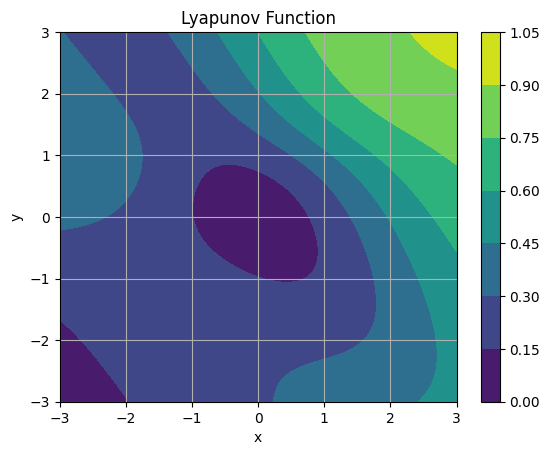

In [21]:
# Plotting the Lyapunov Function
fig, ax = plt.subplots()
# Define grid for plotting
len_sample = [256, 256]
x = np.linspace(-3, 3, len_sample[0])
y = np.linspace(-3, 3, len_sample[1])
X, Y = np.meshgrid(x, y)

# Convert X and Y to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Concatenate X and Y to create input data tensor
input_data = torch.stack((X_tensor, Y_tensor), dim=-1).reshape(-1, 2)
unflatten = torch.nn.Unflatten(0, len_sample)

# Lyapunov Function
with torch.no_grad():
    V = model(input_data)
    cont_out = unflatten(V)
    cont_out = cont_out.detach().numpy()
# Plot the vector field
cp = ax.contourf(X, Y, cont_out[:,:,0])
fig.colorbar(cp)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lyapunov Function')
plt.show()

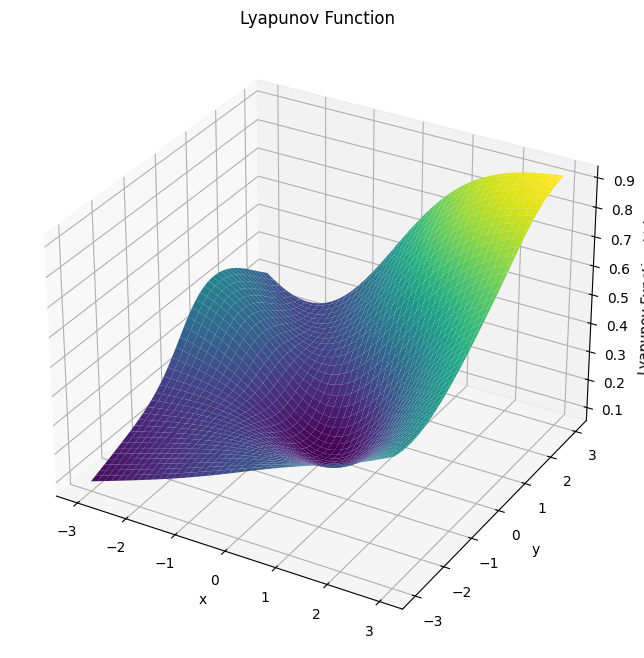

In [22]:
# Plot the Lyapunov function in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, cont_out[:,:,0], cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Lyapunov Function Value')
ax.set_title('Lyapunov Function')
plt.show()

## Ideal Plots for the Lyapunov Function and the Vectors

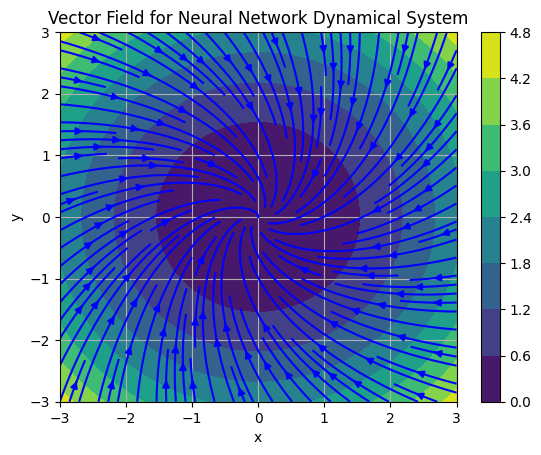

In [23]:
fig, ax = plt.subplots()
# Define grid for plotting
len_sample = [256, 256]
x = np.linspace(-3, 3, len_sample[0])
y = np.linspace(-3, 3, len_sample[1])
X, Y = np.meshgrid(x, y)

# Convert X and Y to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Concatenate X and Y to create input data tensor
input_data = torch.stack((X_tensor, Y_tensor), dim=-1).reshape(-1, 2)
unflatten = torch.nn.Unflatten(0, len_sample)

# Vector Field
with torch.no_grad():
    F = torch.empty(len(input_data),2, dtype=torch.float32)
    for i in range(len(input_data)):
        x = input_data[i,:].unsqueeze(1)
        F[i,:] = torch.reshape(torch.matmul(A,x)[:],(1,-1))
    vect_out = unflatten(F)
    vect_out = vect_out.detach().numpy()
    U = vect_out[:,:, 0]
    V = vect_out[:,:,1]
ax.streamplot(X, Y, U, V, density=1.4, linewidth=None, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field for Neural Network Dynamical System')

# Lyapunov Function
V = torch.empty(len(input_data),1, dtype=torch.float32)
for i in range(len(input_data)):
    x = input_data[i,:]
    x_T = input_data[i,:].unsqueeze(1) 
    V[i] = torch.matmul(torch.matmul(x, P), x_T)
cont_out = unflatten(V)
cont_out = cont_out.detach().numpy()

# Plot the vector field
cp = ax.contourf(X, Y, cont_out[:,:,0])
fig.colorbar(cp)
plt.grid(True)
plt.show()

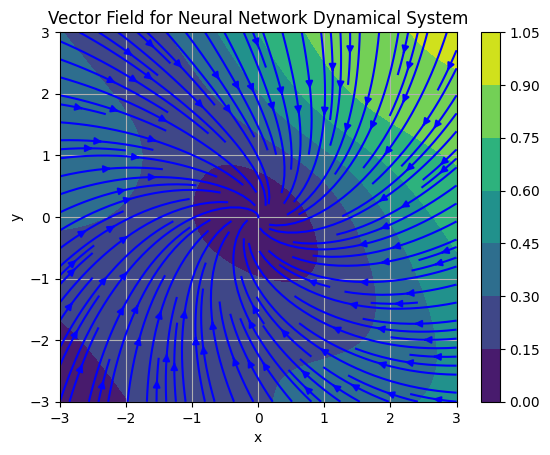

In [24]:
fig, ax = plt.subplots()
# Define grid for plotting
len_sample = [256, 256]
x = np.linspace(-3, 3, len_sample[0])
y = np.linspace(-3, 3, len_sample[1])
X, Y = np.meshgrid(x, y)

# Convert X and Y to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Concatenate X and Y to create input data tensor
input_data = torch.stack((X_tensor, Y_tensor), dim=-1).reshape(-1, 2)
unflatten = torch.nn.Unflatten(0, len_sample)

# Vector Field
with torch.no_grad():
    F = model_f(input_data)
    vect_out = unflatten(F)
    vect_out = vect_out.detach().numpy()
    U = vect_out[:,:, 0]
    V = vect_out[:,:,1]
ax.streamplot(X, Y, U, V, density=1.4, linewidth=None, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field for Neural Network Dynamical System')

# Lyapunov Function
with torch.no_grad():
    V = model(input_data)
    cont_out = unflatten(V)
    cont_out = cont_out.detach().numpy()
# Plot the vector field
cp = ax.contourf(X, Y, cont_out[:,:,0])
fig.colorbar(cp)
plt.grid(True)
plt.show()

## Actual Trajectory

[[-8.7293120e-05 -4.3505459e-04]
 [-8.7292974e-05 -4.3505488e-04]
 [-8.7293120e-05 -4.3505459e-04]
 [-8.7292974e-05 -4.3505488e-04]
 [-8.7293120e-05 -4.3505459e-04]
 [-8.7292974e-05 -4.3505488e-04]
 [-8.7293120e-05 -4.3505459e-04]
 [-8.7292974e-05 -4.3505488e-04]
 [-8.7293120e-05 -4.3505459e-04]
 [-8.7292974e-05 -4.3505488e-04]]


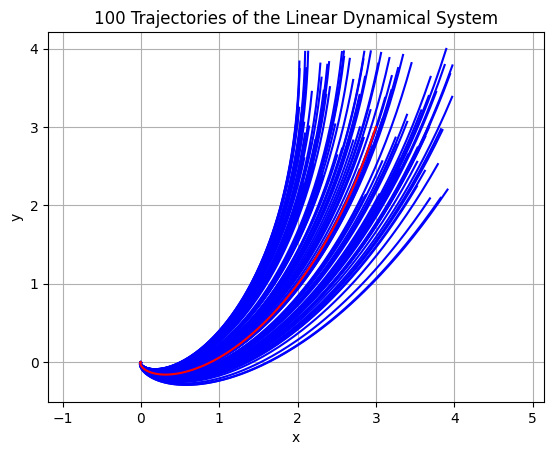

In [31]:
# Plotting trajectories
t = np.linspace(0, 10, 1000)

for i in range(num_trajectories):
    x = np.zeros((len(t), 2))
    x_dot = np.zeros((len(t), 2))
    x[0] = x0_values[i]
    for j in range(1, len(t)):
        x_dot[j-1] = np.dot(A, x[j-1])
        x[j] = x[j-1] + x_dot[j-1] * (t[j] - t[j-1])
    X_data[i*len(t):(i+1)*len(t),:] = x
    X_dot_data[i*len(t):(i+1)*len(t),:] = x_dot
    plt.plot(x[:, 0], x[:, 1],'b')

# Plotting the final trajectory
t = np.linspace(0, 20, 2000)
x = torch.zeros((len(t), 2))
x[0] = torch.tensor([3,3], dtype=torch.float32)
for j in range(1, len(t)):
    x[j] = x[j-1] + model_f(x[j-1]) * (t[j] - t[j-1])
x = x.detach().numpy()
plt.plot(x[:, 0], x[:, 1],'r')

# Plotting the origin
#plt.plot(0, 0, 'ro')
#plt.text(0.1, 0.1, 'Origin (0, 0)', fontsize=10)

plt.xlabel('x')
plt.ylabel('y')
plt.title('100 Trajectories of the Linear Dynamical System')
plt.grid(True)
plt.axis('equal')
plt.show()